In [2]:
%pip install pandas numpy networkx matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import random

# Preprocessing dei dati

In [4]:
df_posts = pd.read_csv("../../../data/post_data.csv")
df_replies = pd.read_csv("../../../data/replies_data.csv")

In [10]:
missing_columns_in_posts = [col for col in df_replies.columns if col not in df_posts.columns]

for col in missing_columns_in_posts:
    df_posts[col] = np.nan

df_combined = pd.concat([df_posts, df_replies], ignore_index=True)
df_combined.columns = [col.lower().replace(" ", "_") for col in df_combined.columns]
df_combined.drop("parent_post_id",axis=1,inplace=True)
df_combined.head()

,post_id,user_id,thread_type,username,profile_picture_url,text_post,like_count,quote_count,caption_text,direct_reply_count,repost_count,following,followed_by,can_reply,reply_control,reshare_count,is_verified
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\n\nFor more pics please ...,7,0.0,Aston Martin for you.\n\nFor more pics please ...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3482097309088055950,38077850387,thread,vita.consacrata,https://scontent-fco2-1.cdninstagram.com/v/t51...,#genere #intelligenzaartificiale,0,0.0,#genere #intelligenzaartificiale,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3481793127636829981,1501070805,thread,robymagno65,https://scontent-fco2-1.cdninstagram.com/v/t51...,#intelligenzaartificiale #foto #ottobre #fotog...,2,0.0,#intelligenzaartificiale #foto #ottobre #fotog...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3438852681247108598,65532133383,thread,news.scienze,https://scontent-fco2-1.cdninstagram.com/v/t51...,La conoscenza della macchina intesa come Intel...,3,0.0,La conoscenza della macchina intesa come Intel...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3446085903746401933,24736383042,thread,rakesh_yadav_200k,https://scontent-fco2-1.cdninstagram.com/v/t51...,#IntelligenzaArtificiale,21,0.0,#IntelligenzaArtificiale,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_combined.shape

(23052, 18)

In [14]:
df = df_combined.drop_duplicates()
# 2. Riempimento dei NaN nelle colonne di conteggio con 0 (queste colonne sono quantitative)
df['like_count'] = df['like_count'].fillna(0)
df['quote_count'] = df['quote_count'].fillna(0)
df['direct_reply_count'] = df['direct_reply_count'].fillna(0)
df['repost_count'] = df['repost_count'].fillna(0)

# 3. Conversione dei tipi di dati
# Assicuriamoci che i conteggi siano di tipo intero
count_columns = ['like_count', 'quote_count', 'direct_reply_count', 'repost_count']

for col in count_columns:
    df[col] = df[col].astype(int)

df.to_csv("dati")

# Identificazione degli utenti influenti

In [26]:
G = nx.DiGraph()


for _, row in df.iterrows():
    user_id = row['user_id']
    post_id = row['post_id']
    thread_type = row['thread_type']
    like_count = row['like_count']
    following = row['following']
    followed_by = row['followed_by']
    
    if user_id not in G:
        G.add_node(user_id, like_count=0)  
    

    G.nodes[user_id]['like_count'] += like_count


    if thread_type == 'reply':

        original_author = df.loc[(df['post_id'] == post_id) & (df['thread_type'] == 'thread'), 'user_id']
        if not original_author.empty:
            original_author_id = original_author.values[0]
            if following:
                G.add_edge(user_id, original_author_id, relation='following')
            if followed_by:
                G.add_edge(original_author_id, user_id, relation='followed_by')
            G.add_edge(user_id, original_author_id, relation='reply')


G_info = {
    'numero_nodi': G.number_of_nodes(),
    'numero_archi': G.number_of_edges(),
    'esempio_nodi': list(G.nodes(data=True))[:5],  # Prime 5 nodi con attributi
    'esempio_archi': list(G.edges(data=True))[:5]  # Prime 5 archi con attributi
}

G_info


{'numero_nodi': 2898,
 'numero_archi': 905,
 'esempio_nodi': [(62926993725, {'like_count': 6088}),
  (38077850387, {'like_count': 0}),
  (1501070805, {'like_count': 34}),
  (65532133383, {'like_count': 187}),
  (24736383042, {'like_count': 726})],
 'esempio_archi': [(62926993725, np.int64(62926993725), {'relation': 'reply'}),
  (38077850387, np.int64(38077850387), {'relation': 'reply'}),
  (1501070805, np.int64(1501070805), {'relation': 'reply'}),
  (65532133383, np.int64(65532133383), {'relation': 'reply'}),
  (24736383042, np.int64(24736383042), {'relation': 'reply'})]}

In [27]:

# Calcolo delle metriche di centralità
centralities = {
    'Degree Centrality': nx.degree_centrality(G),
    'Closeness Centrality': nx.closeness_centrality(G),
    'Betweenness Centrality': nx.betweenness_centrality(G, normalized=True, weight='weight'),
    'PageRank': nx.pagerank(G, alpha=0.85),
    'Katz Centrality': nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-06),
    'Eigenvector Centrality': nx.eigenvector_centrality(G, max_iter=1000),
    'HITS Hub Scores': nx.hits(G, max_iter=1000, tol=1e-08)[0],
    'HITS Authority Scores': nx.hits(G, max_iter=1000, tol=1e-08)[1]
}

# Funzione per stampare i top 10 utenti per ciascuna metrica di centralità
def print_top_centralities(centralities, top_n=10):
    for name, values in centralities.items():
        print(f"\nTop {top_n} utenti per {name}:")
        top_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for i, (node, score) in enumerate(top_nodes, start=1):
            print(f"{i}. Nodo {node}: {score:.4f}")

# Chiamata alla funzione per stampare i risultati
print_top_centralities(centralities)



Top 10 utenti per Degree Centrality:
1. Nodo 62926993725: 0.0007
2. Nodo 38077850387: 0.0007
3. Nodo 1501070805: 0.0007
4. Nodo 65532133383: 0.0007
5. Nodo 24736383042: 0.0007
6. Nodo 7278044187: 0.0007
7. Nodo 2347943083: 0.0007
8. Nodo 8685046141: 0.0007
9. Nodo 3665985737: 0.0007
10. Nodo 5955275713: 0.0007

Top 10 utenti per Closeness Centrality:
1. Nodo 62926993725: 0.0000
2. Nodo 38077850387: 0.0000
3. Nodo 1501070805: 0.0000
4. Nodo 65532133383: 0.0000
5. Nodo 24736383042: 0.0000
6. Nodo 7278044187: 0.0000
7. Nodo 2347943083: 0.0000
8. Nodo 8685046141: 0.0000
9. Nodo 3665985737: 0.0000
10. Nodo 5955275713: 0.0000

Top 10 utenti per Betweenness Centrality:
1. Nodo 62926993725: 0.0000
2. Nodo 38077850387: 0.0000
3. Nodo 1501070805: 0.0000
4. Nodo 65532133383: 0.0000
5. Nodo 24736383042: 0.0000
6. Nodo 7278044187: 0.0000
7. Nodo 2347943083: 0.0000
8. Nodo 8685046141: 0.0000
9. Nodo 3665985737: 0.0000
10. Nodo 5955275713: 0.0000

Top 10 utenti per PageRank:
1. Nodo 62926993725: 0.0

# Modellazione della propagazione

#### Linear Threshold

In [28]:
# Aggiungiamo soglie casuali per ogni nodo nel grafo
for node in G.nodes():
    G.nodes[node]['threshold'] = random.uniform(0, 1)  # Soglia tra 0 e 1

# Funzione del modello a soglia lineare
def linear_threshold_model(G, seed_nodes):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    # Inizializzazione dei pesi degli archi, distribuiti equamente per ogni nodo
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            # Distribuiamo l'influenza tra i vicini in modo uniforme
            weight = 1 / len(neighbors)
            for neighbor in neighbors:
                G.edges[node, neighbor]['influence'] = weight

    # Propagazione iterativa
    while newly_activated:
        next_activated = set()
        for node in G.nodes():
            if node not in activated:
                # Calcoliamo l'influenza totale dei vicini attivi
                total_influence = sum(G.edges[neighbor, node]['influence'] for neighbor in G.predecessors(node) if neighbor in activated)
                
                # Controlliamo se l'influenza totale supera la soglia del nodo
                if total_influence >= G.nodes[node]['threshold']:
                    next_activated.add(node)

        newly_activated = next_activated
        activated.update(newly_activated)

    return activated

In [29]:
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

seed_nodes = [node for node, _ in top_influencers] 
activated_nodes_lt = linear_threshold_model(G, seed_nodes)

print("Numero totale di nodi attivati (LT Model):", len(activated_nodes_lt))


Top Influencers by PageRank: [(62926993725, 0.0008292769905610555), (38077850387, 0.0008292769905610555), (1501070805, 0.0008292769905610555), (65532133383, 0.0008292769905610555), (24736383042, 0.0008292769905610555), (7278044187, 0.0008292769905610555), (2347943083, 0.0008292769905610555), (8685046141, 0.0008292769905610555), (3665985737, 0.0008292769905610555), (5955275713, 0.0008292769905610555)]
Numero totale di nodi attivati (LT Model): 10


#### Independent Cascade

In [30]:
def independent_cascade_model(G, seed_nodes, p=0.1):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    while newly_activated:
        next_activated = set()
        for node in newly_activated:
            neighbors = set(G.neighbors(node)) - activated
            for neighbor in neighbors:
                if np.random.rand() < p:  # probabilità di attivazione
                    next_activated.add(neighbor)
        newly_activated = next_activated
        activated.update(newly_activated)

    return activated


In [31]:
# Selezione degli utenti più influenti
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

# Simulazione con il modello IC
seed_nodes = [node for node, _ in top_influencers]
activated_nodes = independent_cascade_model(G, seed_nodes)
print("Numero totale di nodi attivati:", len(activated_nodes))


Top Influencers by PageRank: [(62926993725, 0.0008292769905610555), (38077850387, 0.0008292769905610555), (1501070805, 0.0008292769905610555), (65532133383, 0.0008292769905610555), (24736383042, 0.0008292769905610555), (7278044187, 0.0008292769905610555), (2347943083, 0.0008292769905610555), (8685046141, 0.0008292769905610555), (3665985737, 0.0008292769905610555), (5955275713, 0.0008292769905610555)]
Numero totale di nodi attivati: 10


# Massimizzazione dell'influenza

In [32]:
# Funzione di valutazione dell'influenza (generica per IC o LT)
def evaluate_spread(G, seed_nodes, model="IC", activation_prob=0.1):
    """
    Valuta la diffusione dell'influenza utilizzando il modello IC o LT.
    Params:
    - G: grafo orientato.
    - seed_nodes: lista di nodi seed.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - Il numero di nodi attivati.
    """
    if model == "IC":
        return len(independent_cascade_model(G, seed_nodes, activation_prob))
    elif model == "LT":
        return len(linear_threshold_model(G, seed_nodes))
    else:
        raise ValueError("Modello non supportato. Usa 'IC' o 'LT'.")


# Algoritmo Greedy per la Massimizzazione dell'Influenza
def influence_maximization_greedy(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo Greedy per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    best_seeds = []
    all_nodes = set(G.nodes())

    for _ in range(k):
        max_influence = -1
        best_node = None

        for node in all_nodes - set(best_seeds):
            spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            if spread > max_influence:
                max_influence = spread
                best_node = node

        best_seeds.append(best_node)

    return best_seeds


# Algoritmo CELF per la Massimizzazione dell'Influenza
def influence_maximization_celf(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo CELF (Cost-Effective Lazy Forward) per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    # Lista delle influenze marginali per ciascun nodo
    marginals = []
    best_seeds = []
    all_nodes = set(G.nodes())

    # Prima valutazione per ogni nodo
    for node in all_nodes:
        spread = evaluate_spread(G, [node], model, activation_prob)
        marginals.append((spread, node))
    marginals.sort(reverse=True, key=lambda x: x[0])

    for _ in range(k):
        while True:
            # Prendi il nodo con la massima influenza marginale
            spread, node = marginals[0]
            # Ricalcola l'influenza marginale se è obsoleto
            new_spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            marginals[0] = (new_spread, node)
            marginals.sort(reverse=True, key=lambda x: x[0])

            # Se il nodo in testa è aggiornato, lo seleziona
            if marginals[0][1] == node:
                best_seeds.append(node)
                marginals.pop(0)
                break

    return best_seeds




In [33]:

# Esempio di esecuzione della massimizzazione dell'influenza
k = 10  # Numero di nodi seed da selezionare
best_seeds_greedy = influence_maximization_greedy(G, k, model="IC")
best_seeds_celf = influence_maximization_celf(G, k, model="IC")

print(f"Miglior set di nodi iniziali con algoritmo Greedy (k={k}):", best_seeds_greedy)
print(f"Miglior set di nodi iniziali con algoritmo CELF (k={k}):", best_seeds_celf)

Miglior set di nodi iniziali con algoritmo Greedy (k=10): [7321698307, 65532133383, 601538568, 46473871369, 45617037320, 53856575502, 1277966, 1543143439, 37052383249, 318414866]
Miglior set di nodi iniziali con algoritmo CELF (k=10): [7321698307, 65532133383, 601538568, 46473871369, 45617037320, 53856575502, 1277966, 1543143439, 37052383249, 318414866]


# Visualizzazione

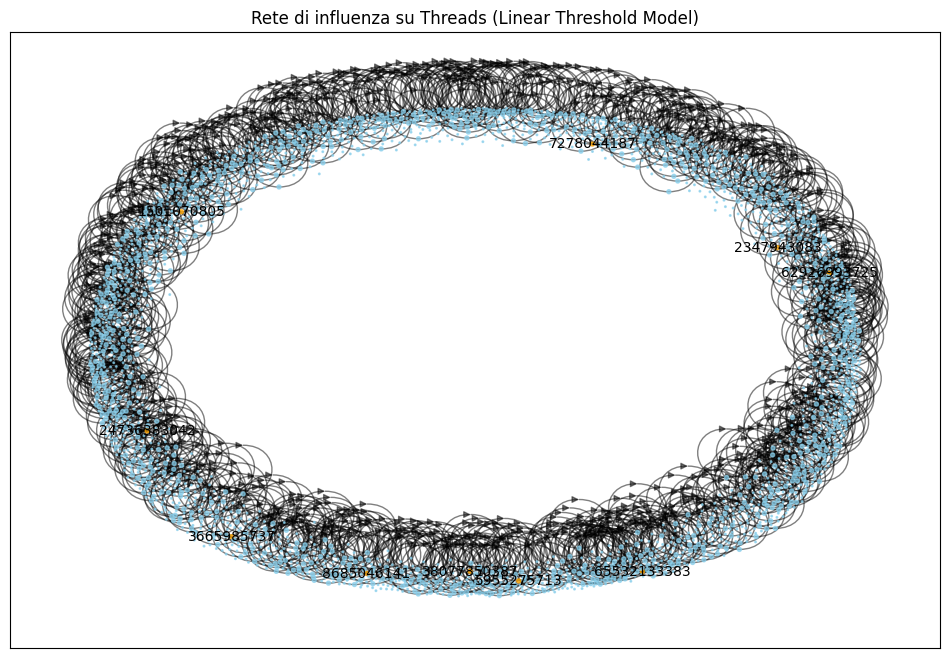

In [25]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)
node_colors = ["orange" if node in activated_nodes_lt else "skyblue" for node in G.nodes()]
node_sizes = [centralities.get("PageRank")[node] * 10000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, {node: node for node, _ in top_influencers}, font_size=10)
plt.title("Rete di influenza su Threads (Linear Threshold Model)")
plt.show()